# Projects in AI and ML HW6 Part 3: Recommender Systems


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
dataset_dir = 'ml-100k'

# Load the ratings data (u.data)
ratings_cols = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv(os.path.join(dataset_dir, 'u.data'), sep='\t', names=ratings_cols, engine='python')

# Load the movies data (u.item) to get movie titles
movies_cols = ['movie_id', 'title'] + [f'col{i}' for i in range(22)]
movies = pd.read_csv(os.path.join(dataset_dir, 'u.item'), sep='|', names=movies_cols, encoding='latin-1', engine='python')
movies = movies[['movie_id', 'title']]


In [3]:
# Display first few rows of ratings and movies
print("Ratings data sample:")
print(ratings.head())
print("\nMovies data sample:")
print(movies.head())


Ratings data sample:
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

Movies data sample:
   movie_id              title
0         1   Toy Story (1995)
1         2   GoldenEye (1995)
2         3  Four Rooms (1995)
3         4  Get Shorty (1995)
4         5     Copycat (1995)


In [4]:
ratings.isnull().sum()

,0
user_id,0
item_id,0
rating,0
timestamp,0


There are no missing values.

In [5]:
ratings['rating'].describe()

,rating
count,100000.000000
mean,3.529860
std,1.125674
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


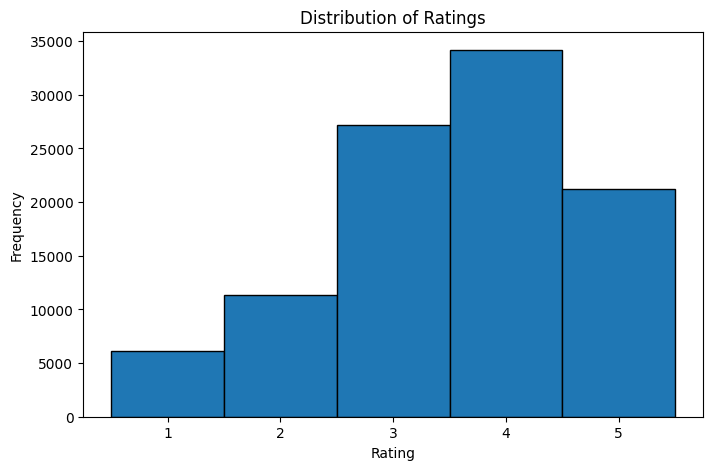

In [6]:
# Plot rating distribution
plt.figure(figsize=(8, 5))
plt.hist(ratings['rating'], bins=np.arange(0.5, 6, 1), edgecolor='black')
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings")
plt.xticks(np.arange(1, 6))
plt.show()

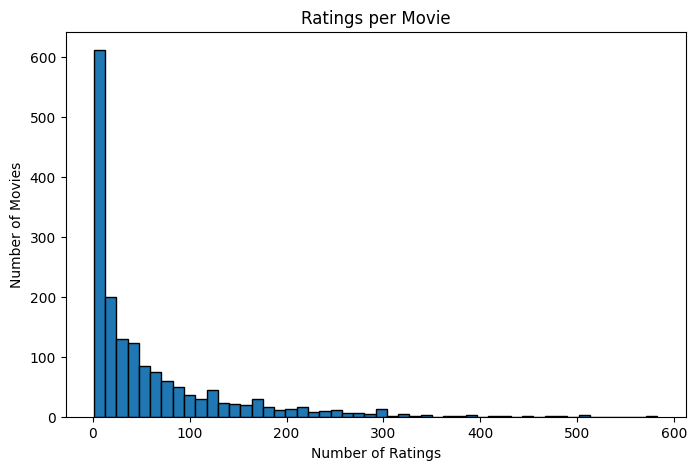

In [7]:
# Number of ratings per movie
ratings_per_movie = ratings.groupby('item_id').size()
plt.figure(figsize=(8, 5))
plt.hist(ratings_per_movie, bins=50, edgecolor='black')
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.title("Ratings per Movie")
plt.show()

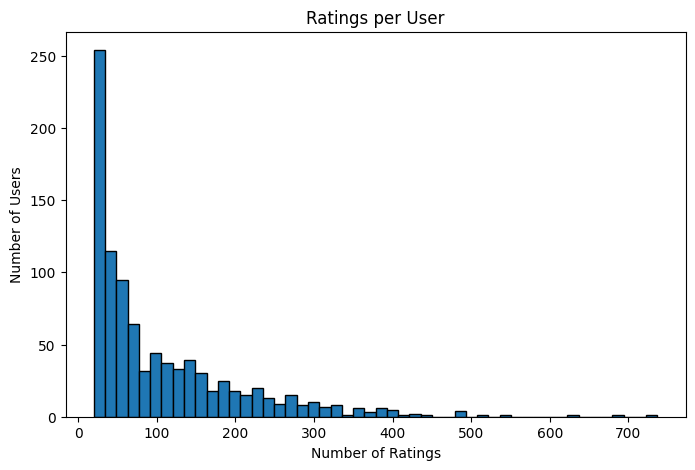

In [8]:
# Number of ratings per user
ratings_per_user = ratings.groupby('user_id').size()
plt.figure(figsize=(8, 5))
plt.hist(ratings_per_user, bins=50, edgecolor='black')
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.title("Ratings per User")
plt.show()

In [9]:
# Create a pivot table with users as rows and movies as columns
user_item_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
print("User-Item matrix shape:", user_item_matrix.shape)


User-Item matrix shape: (943, 1682)


In [5]:
# Split ratings into train and test sets for evaluation
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Create train user-item matrix
train_matrix = train_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# SVD Method
def svd_recommendation(train_matrix, k=20):
    R = train_matrix.values
    U, sigma, VT = np.linalg.svd(R, full_matrices=False)
    # Keep only top k components
    sigma_k = np.diag(sigma[:k])
    U_k = U[:, :k]
    VT_k = VT[:k, :]
    R_pred = np.dot(np.dot(U_k, sigma_k), VT_k)
    return R_pred

# Generate predictions using SVD
svd_pred = svd_recommendation(train_matrix, k=20)
svd_pred_df = pd.DataFrame(svd_pred, index=train_matrix.index, columns=train_matrix.columns)

In [6]:
# ALS Method
def als(R, k=20, lambda_reg=0.1, n_iter=10):
    num_users, num_items = R.shape
    W = (R > 0).astype(float)

    # Initialize latent factor matrices with random values
    U = np.random.rand(num_users, k)
    I = np.random.rand(num_items, k)

    for iteration in range(n_iter):
        for u in range(num_users):
            idx = W[u, :] > 0
            I_i = I[idx, :]
            R_u = R[u, idx]
            if I_i.shape[0] == 0:
                continue
            A = I_i.T.dot(I_i) + lambda_reg * np.eye(k)
            V = I_i.T.dot(R_u)
            U[u, :] = np.linalg.solve(A, V)
        for i in range(num_items):
            idx = W[:, i] > 0
            U_u = U[idx, :]
            R_i = R[idx, i]
            if U_u.shape[0] == 0:
                continue
            A = U_u.T.dot(U_u) + lambda_reg * np.eye(k)
            V = U_u.T.dot(R_i)
            I[i, :] = np.linalg.solve(A, V)
        if iteration % 10 == 0:
            pred = U.dot(I.T)
            error = np.sqrt(mean_squared_error(R[W==1], pred[W==1]))
            print(f"Iteration {iteration+1}/{n_iter}, Training RMSE: {error:.4f}")
    return U, I

R_train = train_matrix.values
als_user_factors, als_item_factors = als(R_train, k=20, lambda_reg=0.1, n_iter=40)
als_pred = np.dot(als_user_factors, als_item_factors.T)
als_pred_df = pd.DataFrame(als_pred, index=train_matrix.index, columns=train_matrix.columns)


Iteration 1/40, Training RMSE: 0.7153
Iteration 11/40, Training RMSE: 0.5008
Iteration 21/40, Training RMSE: 0.4835
Iteration 31/40, Training RMSE: 0.4757


In [8]:
def evaluate_model(pred_df, test_data):
    y_true = []
    y_pred = []

    for row in test_data.itertuples():
        user = row.user_id
        item = row.item_id
        true_rating = row.rating

        # Check if user and item exist in the prediction DataFrame
        if user in pred_df.index and item in pred_df.columns:
            y_true.append(true_rating)
            y_pred.append(pred_df.loc[user, item])

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

# Evaluate SVD model
svd_rmse, svd_mae = evaluate_model(svd_pred_df, test_data)
print(f"SVD Model:  RMSE: {svd_rmse:.4f}, MAE: {svd_mae:.4f}")

# Evaluate ALS model
als_rmse, als_mae = evaluate_model(als_pred_df, test_data)
print(f"ALS Model:  RMSE: {als_rmse:.4f}, MAE: {als_mae:.4f}")

SVD Model:  RMSE: 2.6429, MAE: 2.3731
ALS Model:  RMSE: 1.4947, MAE: 1.0824


I used Root Mean Squared Error and Mean Absolute Error to evaluate this model. The SVD Model produced a RMSE of 2.6429 and MAE of 2.3731 wherewas the aLS model had an RMSE of 1.4947 and MAE of 1.0824. From this, we can see that the ALS model is more accurate than the SVD model (at least in this test). Its iterative latent factor updates are more effecitvely able to capture user preferences.